# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import os
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
# Import models used for testing
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

age   workclass education_level  education-num  marital-status  \
0   39   State-gov       Bachelors           13.0   Never-married   

      occupation    relationship    race    sex  capital-gain  capital-loss  \
0   Adm-clerical   Not-in-family   White   Male        2174.0           0.0   

   hours-per-week  native-country income  
0            40.0   United-States  <=50K

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data.query('income == ">50K"'))

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data.query('income == "<=50K"'))

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) / n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.25%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

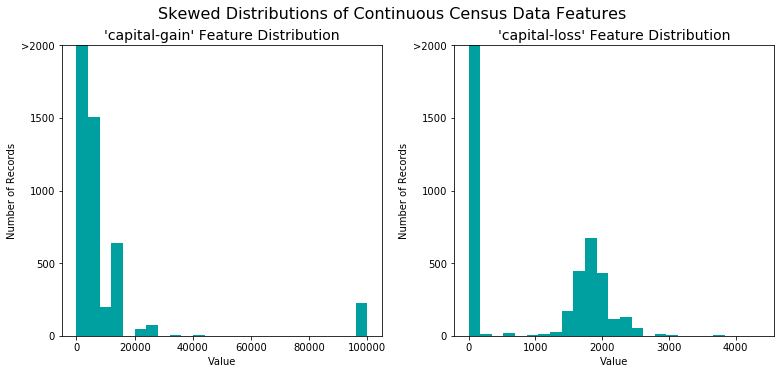

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

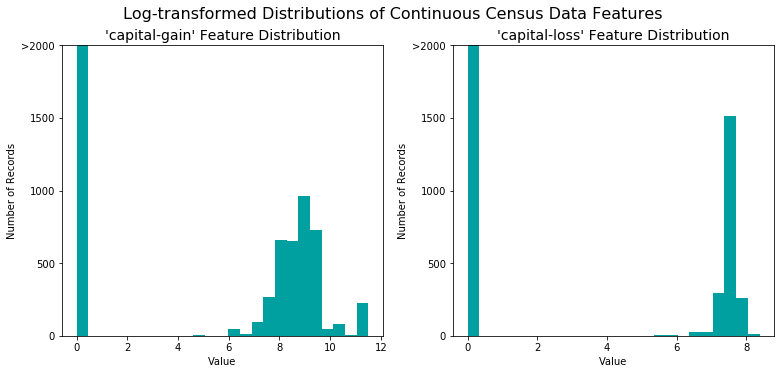

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

age          workclass education_level  education-num  \
0  0.301370          State-gov       Bachelors       0.800000   
1  0.452055   Self-emp-not-inc       Bachelors       0.800000   
2  0.287671            Private         HS-grad       0.533333   
3  0.493151            Private            11th       0.400000   
4  0.150685            Private       Bachelors       0.800000   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0      0.667492           0.0        0.397959   United-States  
1      0.000000           0.0        0.122449   United-States  
2      0.000000           0.0        0.397959   United-States  
3      0.000000           0.0        0.397959   United-States  
4      0.000000           0.0        0.397959            Cuba

### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = [1 if x == '>50K' else 0 for x in income_raw ]

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
# Please note that model_selection was used instead of cross_validation because of a DepreciationWarning
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
#Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
TP = np.sum(income) # Counting the ones as this is the naive case.
FP = len(income) - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

beta = 0.5 # Beta coefficient for F-score

# TODO: Calculate accuracy, precision and recall
# NOTE: Numerator's are casted as floats or else Python 2.7 will apply integer floor division 
accuracy = float(TP) / len(income) #True positives ratio
recall = float(TP) / (TP + FN) # [True Positives/(True Positives + False Negatives)]
precision = float(TP) / (TP + FP) # [True Positives/(True Positives + False Positives)]

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

## Model 1 : `Gaussian Naive Bayes`
#### Real World Application:
Naive Bayes is a good model for classification problems and text based analysis. This model can be applied to problems that can work with Baye's Theorem, the assumption that each feature is indepedent from others. One example where this model can be useful is for filtering emails. By analyzing keywords in emails we are able to create a classifier that filters out spam or for puts them into subcategories. The most common example of this real-world application is spam filtering. When new emails come into an inbox a naive Bayes classifier can use a text classifier to determine if it's spam.
#### Strengths:
One of the main strengths of Naive Bayes is the performance and simplicity. Because it's not computationally intensive, a Naive Bayes model can be used for problems requiring a quick solution or output. Another important strength is the ability to classify categorical features. Compared to models based on regression, a Naive Bayes solution can be optimal for categorical data.
#### Weaknesses:
Some weaknesses of a Naive Bayes model includes the assumption of independence. Baye's theorem stipulates that each feature being measured is independent of others. This assumption can be difficult to find in real-world scenarios and can produce bad estimations. Another weakness of a naive Bayes model is the accuracy of new inputs not found in the training data. The ouput of new data can be unrealiable because it may not be able to make a prediction. 
#### Conclusion:
There are different categorical features in our problem that a naive Bayes model can work well on. A Gaussian Naive Bayes model comes with an additional stipulation of a normally distributed dataset. The naive Bayes model can work efficiently with our dataset training size of 36177 samples.

## Model 2: `3rd Degree Polynomial Support Vector Machine`
#### Real World Application:
Technology is used in the medical field to augment professional's ability to provide care. One area in medecine where Support Vector Machines (SVM) can be useful is cancer diagnosis. There are many different variables in biometric data such as age, blood pressure, family history, enzyme levels, among many others but combined with advanced assessments such as CT and fMRI scan's, the number of features can be in the thousands for cancer diagnosis. The amount of data can be unreasonable for a physician to make a timely and accurate prediction for cancer so there are other methods such as SVM's that can achieve their goals. With a hyper-plane among thousands to millions of data points we can efficiently and effectively create a classifer for cancer with SVM's because of their support for n-dimensional spaces. There are several types of SVM's but a polynomial kernel with 3 degrees can provide an optimal balance between accuracy and efficiency.
#### Strengths:
SVM's can be defined as a hyper-plane in a an n-dimensional space that minimizes the error for a classification problem. This allows them to be effective with problems requiring high dimensional spaces with many different features. Compared to other models, SVM's can work effectively when the number of samples is less than the number of dimensions provided. This also allows them to work effectively for a smaller data set. 

There are different kernels available for SVM's in the scikit-learn library including linear models, radial based, and polynomial SVM's. While SVM's work well with linear implementations, there can be added benefits for a non-linear hyper-plane which includes increased accuracy. For our problem, the dataset is large enough to create a 3rd degree polynomial SVM that may produce more accurate and precise classifications versus a 1st degree or linear classifier. Although we can use greater than 3 degrees for our SVM, we may encounter overfitting which can be apparent with testing data. A radial model may not produce the best SVM after analyzing the visualizations of the data set in question. If there were clear radial or circular clustering of the data, a RBF kernel based SVM may have optimized the classifier. 
#### Weaknesses:
When the data has no clear seperation between classifications a SVM can produce innaccurate results. Our hyper-plane is 3 degrees which allows for non-linear seperations but it can fail if the data often overlaps on a plane. Any type of SVM will fail if the question asks for continuous outputs or probability estimates because they only provide classifiers. Lastly, a SVM can perform poorly if that dataset is too large because it requires additional training time.
#### Conclusion:
Our question considers 13 features that can exist on a multi-dimensional plane with more than 13 dimensions. We're able to build a good classifier for this type of problem with a 3rd degree polynomial SVM. This type of model can work well in an n-dimensional space while also producing accurate results. Our output requires a binary classification of whether or not an individual makes more than 50K annually. SVM's produce classifications which are suitable for binary outputs
## Model 3: `AdaBoost Ensemble Method`
#### Real World Application:
Kaggle is a platform for competitions aiming to produce the most accurate algorithms for a given problem. Many of the most successful algorithms are created using ensemble methods; where a combination of related models can provide the best output. One of the most popular ensemble methods is AdaBoost which utilizes clusters of 'weak predictors' to often generate better predictions than models not based on ensemble methods. Kaggle competitions for various real world applications have their models based on AdaBoost among other ensemble methods.
#### Strengths:
AdaBoost can be useful for binary classification problems such as the one in our question. It can create a better predictor than other models not based on ensemble methods because of its unique iterative approach to training and testing that adjusts the model based on every iteration. The number of smaller models in AdaBoost can have a large amount of parameters for questions that require a large amount of features. AdaBoost can also be used with different 'weak predictors' making it more adaptible for different sets of problems. 
#### Weaknesses:
AdaBoost cannot provide good outputs based on a small amount of data because of the reliance on a large number of 'weak predictors'. With a large enough dataset, AdaBoost also requires more computational complexity and longer computation time. This makes AdaBoost a mediocre candidate for quick and realtime analysis.
#### Conclusion:
AdaBoost can provide a classifier for our problem with much greater accuracy than non ensemble methods. This algorithm can be suited for binary classifications and our output will test whether or not a person has greater than a 50k income in order to develop a mailing list for charity. Our training size is 36177 samples which will be able to provide a good model for CharityML. With what we know about the data and AdaBoost the model is a good candidate for the problem.

### References:
- http://scikit-learn.org/stable/modules/naive_bayes.html
- http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
- http://scikit-learn.org/stable/modules/svm.html
- http://scikit-learn.org/stable/modules/ensemble.html
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/
- https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [12]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test) # Predictions from test set
    predictions_train = learner.predict(X_train[:300]) # Predictions from the first 300 values in the training set
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start #Note that we were predicting two different sets
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    print "\tacc_train:{}\n\tacc_test:{}\n\tf_train:{}\n\tf_test:{}\n\tpred_time:{}".format(
        results['acc_train'], results['acc_test'], results['f_train'], results['f_test'], results['pred_time'])
    
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples.
	acc_train:0.4
	acc_test:0.351796572692
	f_train:0.333333333333
	f_test:0.310134346668
	pred_time:0.0203418731689
GaussianNB trained on 3617 samples.
	acc_train:0.383333333333
	acc_test:0.366058595909
	f_train:0.325091575092
	f_test:0.320258118484
	pred_time:0.0132169723511
GaussianNB trained on 36177 samples.
	acc_train:0.593333333333
	acc_test:0.59767827529
	f_train:0.4125
	f_test:0.420898959576
	pred_time:0.0205790996552
SVC trained on 361 samples.
	acc_train:0.76
	acc_test:0.756218905473
	f_train:0.0
	f_test:0.0
	pred_time:0.253924846649
SVC trained on 3617 samples.
	acc_train:0.833333333333
	acc_test:0.832614704256
	f_train:0.671296296296
	f_test:0.671256454389
	pred_time:2.17560100555
SVC trained on 36177 samples.
	acc_train:0.853333333333
	acc_test:0.837147595357
	f_train:0.719696969697
	f_test:0.6744771707
	pred_time:19.8387072086
AdaBoostClassifier trained on 361 samples.
	acc_train:0.893333333333
	acc_test:0.820674405749
	f_train:0.801282051

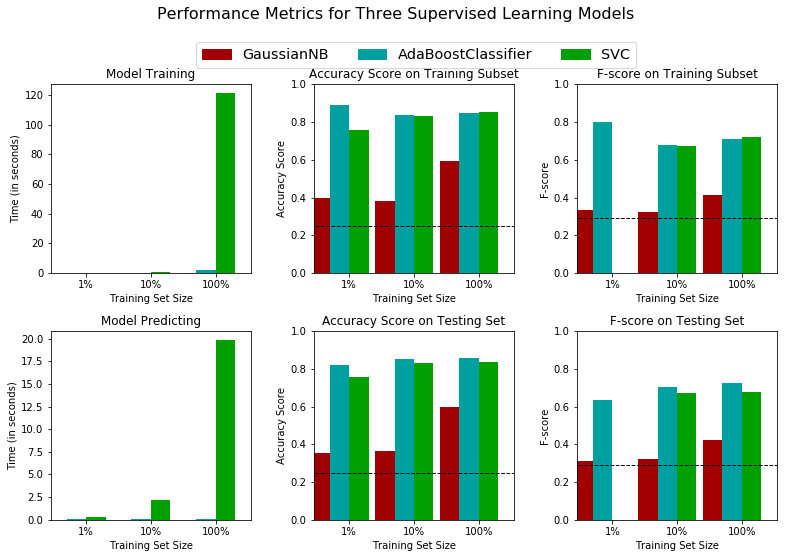

In [13]:
# TODO: Import the three supervised learning models from sklearn

# TODO: Initialize the three models
clf_A = GaussianNB() # Gaussian Naive Bayes
clf_B = SVC(degree = 3) # 3rd Degree Polynomial Support Vector Machine
clf_C = AdaBoostClassifier() # Adaboost Ensemble Method

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
# NOTE: For sample_10 and sample_1, Python 2.7 uses floor division to output an integer,
#       whereas we can also multiply by the appropriate percent but it will return a float
samples_100 = len(y_train)
samples_10 = len(y_train) / 10
samples_1 = len(y_train) / 100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

`NOTE: Benchmarks were performed on a Cloud9 IDE Workspace with a 64 bit Intel Xeon CPU @ 2.30GHz and 1024MB RAM`

## Model 1 : `Gaussian Naive Bayes`
#### Metrics:
Out of the 3 models, the Gaussian Naive Bayes algorithms performed the worst in terms of accuracy and f-score on both the training and testing sets. This model is very simple and may have not worked well because of the failure of the naive independence assumption where some of the features such as workclass and education_level are closely related. The model was almost half as accurate compared to the other algorithms making it a poor classifier for this question. 
#### Prediction & Training Time:
This model was able to train and predict on the data sets quickly. Compared to the other models, Gaussian Naive Bayes trained and predicted the fastest out of all 3. This indicates that the algorithm can be used when a quick result that is not necessarily accurate is needed.
#### Algorithm Suitability:
Because of the poor f-score and accuracy of the model, it is not suitable for this problem. It provided an accuracy of about 59.77% whereas the other models have produced values greater than 80%. Gaussian Naive Bayes may be considered when we are forced to process such a large data set within a very limited time period that other models would not be able to finish training. 
## Model 2: `3rd Degree Polynomial Support Vector Machine`
#### Metrics:
Out of the 3 models, the 3rd Degree Polynomial Support Vector Machine performed the 2nd best on the testing set but performed the 1st best on the training set. This indicates that the SVM model may have benefitted from overfitting because it performed notably worse on the testing set. The SVM model produced an f-score of 0 for the training size of 1% because it produced no true positives which reflects the scarcity of people with an income over 50k in our dataset. After analyzing the predictions for the SVM model at a sample size of 1%, the classifier did not project anyone to have an income 50k or more. Although we are able to catch this phenomenon through the f-score, this method produced a greater than 70% accuracy. This indicates that the SVM requires a large training set for similar datasets and questions. 
#### Prediction & Training Time:
For the samples sizes of 1% and 10%, the 3rd Degree Polynomial Support Vector Machine trained and produced predictions fairly quickly. There was a significant increase in training and testing time for the entire training set. This model took 19.84 seconds which is several times longer than the other two algorithms or 188.22 times longer than AdaBoost. This indicates that the SVM model may not be efficient for large data sets in the context of CharityML. 
#### Algorithm Suitability:
A 3rd Degree Polynomial Support Vector Machine can be a suitable model for Charity ML because it produces an accuracy of greater than 80%. Despite its performance issues with respect to time, the algorithm trained in a reasonable time frame. This algorithm may not be suitable when we are under strict time constraints. 
## Model 3: `AdaBoost Ensemble Method`
#### Metrics:
Out of the 3 models, the AdaBoost Ensemble Method produced the best metrics in terms of accuracy and f-score for the testing set. AdaBoost did not overfit compared to the SVM model so it received a slightly less f-score and accuracy when we tested the training set. When analyzing the differences in metrics for AdaBoost and the SVM model, we find only a slight difference in accuracy and f-score. This indicates that we might want to analyze other aspects of the model such as training time to conclude which algorithm is the best for CharityML such as speed. 
#### Prediction & Training Time:
The model performed relatively quickly compared to the other two algorithms on all samples including the entire training set. AdaBoost was able to iterate quickly over the full training set especially compared to our SVM model. AdaBoost was not able to match the speed of our Gaussian Naive Bayes model but it was subjectively similar. 
#### Algorithm Suitability:
The algorithm predicts with an accuracy of greater than 85.76% on the testing set and an f-score of 0.72 which can provide good results for CharityML. If the model needs to be reproduced, the training and testing time totaled 0.10 seconds for the training set size of 31677. AdaBoost has a good balance of performance and speed in this problem.
## Conclusion: `AdaBoost Ensemble Method`
The AdaBoost Ensemble algorithm is the most accurate model with the highest f-score based on the testing set. The performance of the method was fast and provides additional confidence in reproducibility. The method works equally well from the training set to the testing set most notably when compared to the Support Vector Machine implementation. The algorithm produces a result that is 85% accurate and is able to produce a new model quickly. These characteristics approprite for the task of identifying individuals with an income of at least 50k.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

When we are creating a mailing list for donations to the causes supported by CharityML, it's important to target the right people. We can create software that can accurately decide if someone is likely to donate based on their income and this can increase the total amount of charity collected. A Machine Learning Engineer calls this software a model and they have many to choose from. These models predict attributes that help solve a problem. For CharityML, we want to find people with at least a 50k income and our analysis indicates that an AdaBoost Ensemble model can best solve our question.
    
To put it simply, our AdaBoost model works by predicting whether or not someone earns at least 50k. The model works similarly to how we learn in real life. First, we have many different examples with all their corresponding answers. This is called our training set and the more we train the better we can predict things. The AdaBoost model runs through all the examples and their answers to get a good idea of how to guess whether someone earns enough income. We can test our model by giving it some examples without the answers and see how accurate it is, also known as the testing set. When comparing the predicted answers and the correct answers, AdaBoost is 85% accurate! Not all models are the same, and AdaBoost works a little differently from others. Imagine a classroom of 50 unique people going through the examples and answers. After every example, everyone is tested to see if they are able to find the correct answer. After all the examples are done we can find the accuracy of each of the 50 people. Then we can ask the entire classroom of the 50 unique people for a new prediction by finding the majority vote while giving the people who were more accurate more votes. AdaBoost works very similar to this classroom metaphor where every unique person is called a 'weak learner' and the classroom is called the 'ensemble'.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [18]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = AdaBoostClassifier()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [50, 100, 200, 600], #n_estimators for number of weak_estimators
             'algorithm': ['SAMME', 'SAMME.R']} #algorithms for different implementations

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5) #Use the beta specified earlier

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

# Print the parameters for the best model
print "Parameters for optimized model: {}".format(best_clf.get_params())

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8660
Final F-score on the testing data: 0.7415
Parameters for optimized model: {'n_estimators': 600, 'base_estimator': None, 'random_state': None, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              | 0.8576            | 0.8660          |
| F-score        | 0.2917              | 0.7246            | 0.7451          |


**Answer: **

#### What is your optimized model's accuracy and F-score on the testing data?
The model chosen was AdaBoost and the accuracy was 86.60% while the f-score was 0.7451 based on the testing data.
#### Are these scores better or worse than the unoptimized model?
The optimized model is slightly better than the unoptimized model where the accuracy is 0.0084 units greater while the f-score increased by 0.0205 units. If we compare the differences in the parameters for the default AdaBoostClassifier and the optimized model we see that the optimized solution changed the n_estimators and utilized 600 'weak learners' versus the previous default of 50. 
#### How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in Question 1?_
The naive predictor was a poor model to use in this question and the optimized model is 3.49 times more accurate while the f-score increased by 0.4534 units.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
#### 1. `occupation`
Different occupations pay different amounts where we can expect individuals in clerical and administation jobs making less than executive and managerial positions. There are 14 different classifications for this feature that allows specificity and enough generalizations to be useful. Income often comes directly from a person's occupation so we can expect this to be the most important for prediction.
#### 2. `hours-per-week`
There is a positive linear correlation to the number of hours worked and the amount of pay because most organizations use this number to determine paychecks. Individuals with a higher number of hours worked per week get paid more than others who work less, all else held constant. This can be an important feature to determine income for our question.
#### 3. `education_level`
Generally, individuals who are highly educated earn more than those with less education. With greater education comes more skill and this can lead higher incomes. There are 16 classifications for this feature to allow greater specificity for our model to predict outcomes. This feature can impact the predictions for our model so it's important to consider. 
#### 4. `workclass`
Workclass can also be interpreted as the industry an individual is employed under. There are 8 classifications and 3 of them indicate that the individual might have no income such as the 'Never-worked' label. The other 5 are consist of the labels 'Private', 'Self-emp-inc', 'Federal-gov', 'Local-gov', and 'State-gov' that can indicate income. The feature contains information that can be used to predict income. 
#### 5. `age`
This is a continuous value without labels or classifications. If we assume that older individuals earn more than younger counterparts than it can be used to project income. This assumption may only hold true up to a certain age and there are other features in the data that have a direct impact on income. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

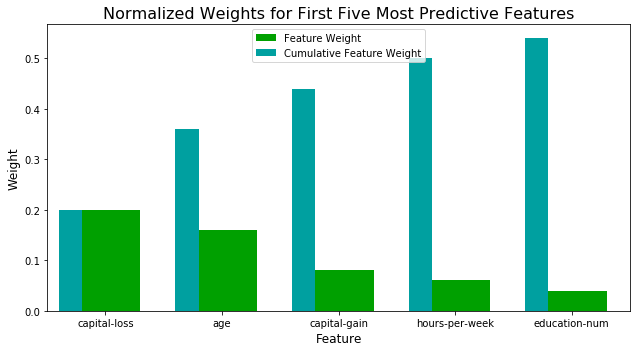

In [20]:
# TODO: Import a supervised learning model that has 'feature_importances_'
# NOTE: The algorithm chosen is AdaBoostClassifier and has already been imported
clf_importance = AdaBoostClassifier()

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf_importance.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

#### How do these five features compare to the five features you discussed in **Question 6**?
Out of the five features I discussed, only 2 were included in the first five most predictive features. My analysis did not include 'capital-loss' or 'capital-gain' but the chosen model described them as the 1st and 3rd most important features in the data. The discussed feature that was nearest to the true order was 'hours-per-week' where I ordered it as the 2nd most important while the model ordered it as the 4th most important.
#### If you were not close, why do you think these features are more relevant?
The two features 'capital-loss' and 'capital-gain' describe the amount an individual lost or gained after selling some assets. These features were more important in identifying people with an income greater than 50k because individuals with less income may not have enough assets to report a capital gain or loss. This is important for our question because most of the people in our data don't meet our income threshold so features that have stronger correlations with higher incomes are more relevant to our solution.

The feature label 'education_num' was similar to the feature I discussed called 'education_level'. These two describe very similar characterisitcs where 'education_num' is a continuous number and 'education_level' is a classification. One thing to note is that the feature I listed first was 'occupation' but it wasn't listed in the five most relvant features according to our model. We can hypothesize that according to our data, education is more important than occupation in determining whether someone has an income greater than 50k. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [21]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8660
F-score on testing data: 0.7415

Final Model trained on reduced data
------
Accuracy on testing data: 0.8427
F-score on testing data: 0.7048


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

#### How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
The model's f-score and accuracy were reduced where the f-score saw a larger reduction. This indicates that reducing the feature set can negatively impact the model's effectiveness. With more features we're able to make better predictions but we require more data to accommadate.
#### If training time was a factor, would you consider using the reduced data as your training set?
The training time was not significantly different after reducing the feature space and there was a small but significant difference in the f-score. We are reducing the feature set size from 13 to 5 which is more than half of the number of features. This leads me to conclude that if time was a factor, I wouldn't consider using reduced data for an AdaBoost model for our training set. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.